# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1ogme9BJeHb2IZ6UREavUorF--nnxoWCYAAi8AZ4Q5jQ/edit?usp=sharing) and [grading rubric](https://docs.google.com/document/d/1XI9Yq_e-U-D3iH4jTPAtNteeP2Q9mtJ9NKbePWKeN_g/edit?usp=sharing)

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [ ]:
# All import statements needed for the project, for example:

import pandas as pd
import numpy as np
import time

import json
import pathlib
import urllib.parse
import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely

import sqlalchemy as db
from sqlalchemy import create_engine
from sqlalchemy.orm import declarative_base
import subprocess
import psycopg2
from geoalchemy2 import WKTElement, Geometry
from shapely.geometry import Point
import requests

from sqlalchemy import create_engine, text

pd.set_option('display.max_columns', None)


In [ ]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "qmf4vTidE7TMehCHe78KV7SIM"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/resource/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "Group6Finalproject"
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_HOST = "localhost"  
DB_PORT = "5432" 

#DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [ ]:
# Make sure the QUERY_DIRECTORY & DATA_DIR exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()
if not (DATA_DIR/"data_cleaned").exists():    
    (DATA_DIR/"data_cleaned").mkdir()


## Part 1: Data Preprocessing

In [ ]:
def download_nyc_geojson_data(url, force=False):
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = DATA_DIR / url_path
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        
        headers = {'X-App-Token': NYC_DATA_APP_TOKEN}
        params = {
        "$limit": 50000, 
        "$offset": 0,
        "$select": "*",
        }
        response = requests.get(url, headers=headers, params=params)
        
        with open(filename, "w") as f:
            json.dump(response.json(), f)
        print(f"Done downloading {url}.")

    else:
        print(f"Reading from {filename}...")

    return filename

## Zillow Data

In [ ]:
def load_and_clean_zillow_data():
    df = pd.read_csv(ZILLOW_DATA_FILE)
    #Only need New York
    df = df[df['City']=='New York']
    #Remove unneeded columns
    df.drop(columns=['RegionID', 'SizeRank','RegionType','StateName','State','City','Metro','CountyName'],inplace=True)
    
    # Normalize column names used later
    column_name_mapping ={
    '2023-01-31': 'Jan_2023', '2023-02-28': 'Feb_2023', '2023-03-31': 'Mar_2023',
    '2023-04-30': 'Apr_2023', '2023-05-31': 'May_2023', '2023-06-30': 'Jun_2023',
    '2023-07-31': 'Jul_2023', '2023-08-31': 'Aug_2023', '2023-09-30': 'Sep_2023',
    '2023-10-31': 'Oct_2023', '2023-11-30': 'Nov_2023', '2023-12-31': 'Dec_2023',
    '2024-01-31': 'Jan_2024', 
    }
    
    df.rename(columns=column_name_mapping, inplace=True) 
    df.rename(columns={'RegionName': 'zip_code'}, inplace=True)
    
    for col in df.columns:
        if col != 'zip_code':
            df[col] = pd.to_numeric(df[col])
    df['zip_code'] = df['zip_code'].astype("string")
    df1 = df.copy()
    
    
    df1['mean'] = df1.iloc[:, 1:].mean(axis=1, skipna=True)
    
    clean_columns = ['zip_code', 'Mar_2023', 'Apr_2023', 'May_2023', 
                 'Jun_2023', 'Jul_2023', 'Aug_2023', 'Sep_2023', 'Oct_2023',
                 'Nov_2023', 'Dec_2023', 'Jan_2024','mean']
    df1 = df1[clean_columns]
    
    df1.iloc[:,1:] = df1.iloc[:,1:].fillna(df.iloc[:,1:].mean())
    
    return df1

In [ ]:
df_zillow_data = load_and_clean_zillow_data()

In [ ]:
df_zillow_data

,zip_code,Mar_2023,Apr_2023,May_2023,Jun_2023,Jul_2023,Aug_2023,Sep_2023,Oct_2023,Nov_2023,Dec_2023,Jan_2024,mean
5,11385,2775.252914,2808.032817,2853.002812,2891.976411,2912.450226,2938.806070,2955.446452,2944.372938,2918.206892,2888.346480,2880.094236,2406.988898
7,11208,2391.620952,2436.143335,2482.460397,2611.911540,2574.997140,2545.014303,2534.897818,2553.020263,2648.498763,2642.337313,2704.611111,2420.442613
13,11236,3023.440752,3045.117937,3064.026181,3101.499208,3130.634702,2269.106840,2338.199472,2360.574201,2387.586858,2402.457491,2487.500000,2374.237477
14,10467,1743.285101,1695.177852,1748.353876,1825.836631,1883.032947,1899.143080,1958.261105,1987.880524,2066.328960,2011.173298,2036.252778,1526.664293
15,11373,2586.230171,2595.856831,2570.915900,2608.660190,2596.701012,2660.168354,2642.649107,2670.325604,2668.151494,2672.319180,2689.050000,2450.386974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,10280,4271.558141,4412.441417,4483.983624,4533.245597,4613.955728,4621.894250,4647.778216,4569.463105,4559.732705,4424.083102,4307.705803,3739.894862
6475,10282,6981.125874,7036.754731,6980.121285,7092.098977,7124.896337,6962.699767,6866.420029,6739.684950,6868.710937,6777.653684,6906.666667,6622.055559
6482,11109,4392.799907,4485.793991,4536.940052,4553.962333,4646.028252,4696.226932,4738.496958,4659.700057,4571.279711,4486.991402,4481.239177,3715.367695
6553,10006,3758.986468,3854.075866,3958.198260,3976.243216,3968.035550,3949.256636,3970.440764,3999.572587,4004.023222,3921.431891,3914.000000,3477.478053


####

## Zipcode Data

In [ ]:
def load_and_clean_zipcodes(zipcode_datafile):
    zipcode_data = gpd.read_file(zipcode_datafile)
    zipcode_data = zipcode_data[['ZIPCODE', 'geometry']]
    zipcode_data = zipcode_data.to_crs(epsg=4326)
    zipcode_data = zipcode_data.rename(columns={'ZIPCODE': 'zipcode'})
    zipcode_data = zipcode_data.dropna()
    
    return zipcode_data


In [ ]:
geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

In [ ]:
geodf_zipcode_data

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."
...,...,...
258,10310,"POLYGON ((-74.12065 40.64104, -74.12057 40.641..."
259,11693,"POLYGON ((-73.84076 40.62536, -73.84306 40.627..."
260,11249,"POLYGON ((-73.95805 40.72442, -73.95772 40.724..."
261,10162,"POLYGON ((-73.95133 40.76931, -73.95165 40.769..."


####

## Tree Data

In [ ]:
def download_and_clean_tree_data():
    url=f"{BASE_NYC_DATA_URL}{NYC_DATA_TREES}?$$app_token={NYC_DATA_APP_TOKEN}&$limit=10000"
    filename=download_nyc_geojson_data(url)
    df=gpd.read_file(filename)
    
    # To keep the necessary columns
    df_selected=df[['tree_id','zipcode','address','health','zip_city','spc_common','status','sidewalk','borocode','block_id','geometry']]
    
    
    # Drop rows with missing values
    df_selected=df_selected.dropna()
    
    # Convert column names to lowercase
    df_selected.columns = [col.lower() for col in df_selected.columns]
    
    # Change the SRID to a specific value (EPSG 4326 - WGS 84)
    df_selected = df_selected.to_crs(epsg=4326)
    
    
    
    return df_selected


In [ ]:
geodf_tree_data = download_and_clean_tree_data()


Reading from data\resource\5rq2-4hqu.geojson...


In [ ]:
geodf_tree_data

,tree_id,zipcode,address,health,zip_city,spc_common,status,sidewalk,borocode,block_id,geometry
0,180683,11375,108-005 70 AVENUE,Fair,Forest Hills,red maple,Alive,NoDamage,4,348711,POINT (-73.84422 40.72309)
1,200540,11357,147-074 7 AVENUE,Fair,Whitestone,pin oak,Alive,Damage,4,315986,POINT (-73.81868 40.79411)
2,204026,11211,390 MORGAN AVENUE,Good,Brooklyn,honeylocust,Alive,Damage,3,218365,POINT (-73.93661 40.71758)
3,204337,11211,1027 GRAND STREET,Good,Brooklyn,honeylocust,Alive,Damage,3,217969,POINT (-73.93446 40.71354)
4,189565,11215,603 6 STREET,Good,Brooklyn,American linden,Alive,Damage,3,223043,POINT (-73.97598 40.66678)
...,...,...,...,...,...,...,...,...,...,...,...
49995,256994,11102,26-031 28 STREET,Good,Astoria,sycamore maple,Alive,NoDamage,4,301525,POINT (-73.92156 40.77005)
49996,237055,11225,502 MONTGOMERY STREET,Good,Brooklyn,katsura tree,Alive,NoDamage,3,227121,POINT (-73.94799 40.66518)
49997,237241,10035,100 EAST 123 STREET,Good,New York,London planetree,Alive,Damage,1,110425,POINT (-73.94002 40.80402)
49998,246580,11370,31-045 77 STREET,Good,East Elmhurst,London planetree,Alive,Damage,4,341646,POINT (-73.89038 40.75739)


####

## NYC Open Data

In [ ]:
def download_and_clean_311_data():
    
    BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/resource/"
    NYC_DATA_311 = "erm2-nwe9.json"
    
    
    data_url = BASE_NYC_DATA_URL + NYC_DATA_311
    columns = "unique_key,created_date,closed_date,complaint_type,incident_zip,latitude,longitude"
    start_date = "2023-03-01"
    end_date = "2024-02-29"
    limit = 50000
    offset = 0
    total_rows = 0
    headers = {"X-App-Token": NYC_DATA_APP_TOKEN}
    all_data = []
    
    while True:
        query = f"$select={columns}&$where=created_date >= '{start_date}T00:00:00.000' AND created_date <= '{end_date}T23:59:59.999' AND latitude IS NOT NULL&$limit={limit}&$offset={offset}"
        paginated_url = f"{data_url}?{query}"
        response = requests.get(paginated_url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if data:
                all_data.extend(data)
                total_rows += len(data)
                offset += limit
            else:
                break
        else:
            break
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    df = df.rename(columns={'incident_zip':'zip_code'})
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
    )
    return gdf


In [ ]:
geodf_311_data = download_and_clean_311_data()

In [ ]:
geodf_311_data

,unique_key,created_date,closed_date,complaint_type,zip_code,latitude,longitude,geometry
0,60462274,2024-02-29T23:59:31.000,2024-03-01T00:00:00.000,Building/Use,11204,40.61984470790165,-73.98238922950797,POINT (-73.98239 40.61984)
1,60452687,2024-02-29T23:59:27.000,2024-03-02T10:47:34.000,HEAT/HOT WATER,11209,40.62326209885787,-74.03020533301675,POINT (-74.03021 40.62326)
2,60451322,2024-02-29T23:59:13.000,2024-03-01T00:48:14.000,Noise - Vehicle,11237,40.700045051717986,-73.91198085791687,POINT (-73.91198 40.70005)
3,60449904,2024-02-29T23:58:39.000,2024-03-01T01:13:49.000,Blocked Driveway,11429,40.713059105370455,-73.75260269888014,POINT (-73.75260 40.71306)
4,60452421,2024-02-29T23:58:22.000,2024-03-01T00:24:56.000,Noise - Commercial,11419,40.68414711447904,-73.83262819498826,POINT (-73.83263 40.68415)
...,...,...,...,...,...,...,...,...
3236495,56926615,2023-03-01T00:00:28.000,2023-03-23T10:21:29.000,PAINT/PLASTER,10455,40.81318657341566,-73.90889419223052,POINT (-73.90889 40.81319)
3236496,56928634,2023-03-01T00:00:27.000,2023-03-02T10:05:55.000,HEAT/HOT WATER,10458,40.86728995413362,-73.88680150902282,POINT (-73.88680 40.86729)
3236497,56923967,2023-03-01T00:00:22.000,2023-03-01T00:21:36.000,Noise - Vehicle,11225,40.6557600902707,-73.95990482658175,POINT (-73.95990 40.65576)
3236498,56924139,2023-03-01T00:00:03.000,2023-03-01T02:00:53.000,Noise - Residential,10457,40.85556798829767,-73.89935066841451,POINT (-73.89935 40.85557)


####

In [ ]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   263 non-null    object  
 1   geometry  263 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.2+ KB


In [ ]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [ ]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 5 to 6630
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   zip_code  144 non-null    string 
 1   Mar_2023  144 non-null    float64
 2   Apr_2023  144 non-null    float64
 3   May_2023  144 non-null    float64
 4   Jun_2023  144 non-null    float64
 5   Jul_2023  144 non-null    float64
 6   Aug_2023  144 non-null    float64
 7   Sep_2023  144 non-null    float64
 8   Oct_2023  144 non-null    float64
 9   Nov_2023  144 non-null    float64
 10  Dec_2023  144 non-null    float64
 11  Jan_2024  144 non-null    float64
 12  mean      144 non-null    float64
dtypes: float64(12), string(1)
memory usage: 15.8 KB


In [ ]:
df_zillow_data.head()

,zip_code,Mar_2023,Apr_2023,May_2023,Jun_2023,Jul_2023,Aug_2023,Sep_2023,Oct_2023,Nov_2023,Dec_2023,Jan_2024,mean
5,11385,2775.252914,2808.032817,2853.002812,2891.976411,2912.450226,2938.806070,2955.446452,2944.372938,2918.206892,2888.346480,2880.094236,2406.988898
7,11208,2391.620952,2436.143335,2482.460397,2611.911540,2574.997140,2545.014303,2534.897818,2553.020263,2648.498763,2642.337313,2704.611111,2420.442613
13,11236,3023.440752,3045.117937,3064.026181,3101.499208,3130.634702,2269.106840,2338.199472,2360.574201,2387.586858,2402.457491,2487.500000,2374.237477
14,10467,1743.285101,1695.177852,1748.353876,1825.836631,1883.032947,1899.143080,1958.261105,1987.880524,2066.328960,2011.173298,2036.252778,1526.664293
15,11373,2586.230171,2595.856831,2570.915900,2608.660190,2596.701012,2660.168354,2642.649107,2670.325604,2668.151494,2672.319180,2689.050000,2450.386974


In [ ]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3236500 entries, 0 to 3236499
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   unique_key      object  
 1   created_date    object  
 2   closed_date     object  
 3   complaint_type  object  
 4   zip_code        object  
 5   latitude        object  
 6   longitude       object  
 7   geometry        geometry
dtypes: geometry(1), object(7)
memory usage: 197.5+ MB


In [ ]:
geodf_311_data.head()

,unique_key,created_date,closed_date,complaint_type,zip_code,latitude,longitude,geometry
0,60462274,2024-02-29T23:59:31.000,2024-03-01T00:00:00.000,Building/Use,11204,40.61984470790165,-73.98238922950797,POINT (-73.98239 40.61984)
1,60452687,2024-02-29T23:59:27.000,2024-03-02T10:47:34.000,HEAT/HOT WATER,11209,40.62326209885787,-74.03020533301675,POINT (-74.03021 40.62326)
2,60451322,2024-02-29T23:59:13.000,2024-03-01T00:48:14.000,Noise - Vehicle,11237,40.700045051717986,-73.91198085791687,POINT (-73.91198 40.70005)
3,60449904,2024-02-29T23:58:39.000,2024-03-01T01:13:49.000,Blocked Driveway,11429,40.713059105370455,-73.75260269888014,POINT (-73.75260 40.71306)
4,60452421,2024-02-29T23:58:22.000,2024-03-01T00:24:56.000,Noise - Commercial,11419,40.68414711447904,-73.83262819498826,POINT (-73.83263 40.68415)


In [ ]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 47589 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tree_id     47589 non-null  object  
 1   zipcode     47589 non-null  object  
 2   address     47589 non-null  object  
 3   health      47589 non-null  object  
 4   zip_city    47589 non-null  object  
 5   spc_common  47589 non-null  object  
 6   status      47589 non-null  object  
 7   sidewalk    47589 non-null  object  
 8   borocode    47589 non-null  object  
 9   block_id    47589 non-null  object  
 10  geometry    47589 non-null  geometry
dtypes: geometry(1), object(10)
memory usage: 4.4+ MB


In [ ]:
geodf_tree_data.head()

,tree_id,zipcode,address,health,zip_city,spc_common,status,sidewalk,borocode,block_id,geometry
0,180683,11375,108-005 70 AVENUE,Fair,Forest Hills,red maple,Alive,NoDamage,4,348711,POINT (-73.84422 40.72309)
1,200540,11357,147-074 7 AVENUE,Fair,Whitestone,pin oak,Alive,Damage,4,315986,POINT (-73.81868 40.79411)
2,204026,11211,390 MORGAN AVENUE,Good,Brooklyn,honeylocust,Alive,Damage,3,218365,POINT (-73.93661 40.71758)
3,204337,11211,1027 GRAND STREET,Good,Brooklyn,honeylocust,Alive,Damage,3,217969,POINT (-73.93446 40.71354)
4,189565,11215,603 6 STREET,Good,Brooklyn,American linden,Alive,Damage,3,223043,POINT (-73.97598 40.66678)


## Part 2: Storing Data

In [ ]:
def setup_new_postgis_database(username, db_name, password):
    conn = psycopg2.connect(
        dbname=db_name, 
        user=username,
        password='postgres',  
        host='localhost',   
        port='5432'         
    )
    cursor = conn.cursor()
    cursor.close()
    conn.commit()
    conn.close()

In [ ]:
setup_new_postgis_database(DB_USER, DB_NAME)

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [ ]:
engine = db.create_engine(DB_URL)

In [ ]:
# If using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables.
# You may be creating more tables depending on how you're setting up your constraints/relationships
# or if you're completing the extra credit.

ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
    id INTEGER PRIMARY KEY,
    zipcode CHAR(5),
    geometry GEOMETRY (Polygon,4326)
);

"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_311 (
    unique_key VARCHAR(50) PRIMARY KEY,
    created_date VARCHAR(50),
    closed_date VARCHAR(50),
    complaint_type VARCHAR(100),
    zip_code VARCHAR(5),
    latitude VARCHAR(50),
    longitude VARCHAR(50),
    geometry GEOMETRY(POINT, 4326)
);

"""

NYC_TREE_SCHEMA = """
DROP TABLE IF EXISTS trees;
CREATE TABLE IF NOT EXISTS trees (
    tree_id VARCHAR(50) PRIMARY KEY,
    zipcode VARCHAR(10),
    address VARCHAR(255),
    health VARCHAR(255), 
    zip_city VARCHAR(255), 
    spc_common VARCHAR(255),
    status VARCHAR(255),
    sidewalk VARCHAR(255),
    borocode VARCHAR(10),
    block_id VARCHAR(255),
    geometry GEOMETRY (Point,4326)
);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS rents
(
    id INTEGER PRIMARY KEY,
    zip_code CHAR(5),
    Jan_2023 FLOAT,
    Feb_2023 FLOAT,
    Mar_2023 FLOAT,
    Apr_2023 FLOAT,
    May_2023 FLOAT,
    Jun_2023 FLOAT,
    Jul_2023 FLOAT,
    Aug_2023 FLOAT,
    Sep_2023 FLOAT,
    Oct_2023 FLOAT,
    Nov_2023 FLOAT,
    Dec_2023 FLOAT,
    Jan_2024 FLOAT,
    mean FLOAT
);
"""

In [ ]:
DB_SCHEMA_FILE = "Group6project.sql"
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [ ]:
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER} password={DB_PASSWORD}")
cur = conn.cursor()
with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

In [ ]:
def write_dataframes_to_table(tablename_to_dataframe):
    # write INSERT statements or use pandas/geopandas to write SQL
    engine = create_engine(DB_URL)
    
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            temp_df = dataframe.copy()
            temp_df['the_geom'] = temp_df['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None)
            temp_df.drop('geometry',axis=1,inplace=True)
            temp_df.to_sql(tablename, engine, if_exists='replace', index=False, 
                           dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}) 
            
        else:
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [ ]:
tablename_to_dataframe = {
    "zipcodes": geodf_zipcode_data,
    "complaints": geodf_311_data,
    "trees": geodf_tree_data,
    "rents": df_zillow_data,
}

In [ ]:
write_dataframes_to_table(tablename_to_dataframe)

## Part 3: Understanding the Data

In [ ]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as file:
        file.write(query)

#### Sanity Check Query

In [ ]:
QUERY = """
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'rents' ;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY))
    for row in result:
        print(row)

('mean',)
('Mar_2023',)
('Apr_2023',)
('May_2023',)
('Jun_2023',)
('Jul_2023',)
('Aug_2023',)
('Sep_2023',)
('Oct_2023',)
('Nov_2023',)
('Dec_2023',)
('Jan_2024',)
('zip_code',)


### Query 1: Incidents per Zip Code 

In [ ]:
QUERY_1_FILENAME = QUERY_DIR / "complains_per_Zip_Code.sql"

QUERY_1 = """
SELECT zip_code, COUNT(*) AS complaint_count
FROM complaints
WHERE created_date >= '2023-03-01' AND created_date <= '2024-02-29'
GROUP BY zip_code
ORDER BY complaint_count DESC;
"""


In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

## Query 2: Green Areas by Zip Code

In [ ]:
QUERY_2_FILENAME = QUERY_DIR / "Top10_Zip_Codes_by_trees.sql"

QUERY_2 = """
SELECT zipcode, COUNT(*) AS tree_count
FROM trees
GROUP BY zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10306', 2355)
('11230', 1545)
('10466', 1400)
('11375', 1215)
('11215', 1172)
('10312', 1115)
('11426', 1107)
('11105', 1056)
('11218', 1011)
('11372', 970)


In [ ]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

## Zipcode Data

## Query 3: Affordable Areas and Most Trees

In [ ]:
QUERY_3_FILENAME = QUERY_DIR / "Affordable_Areas_Most_Trees.sql"

QUERY_3 =  """
SELECT t.zipcode AS zip_code, 
       TO_CHAR(AVG(z."Jan_2024"), 'FM9,999,999.00') AS average_rent
FROM trees t
JOIN rents z ON t.zipcode = CAST(z.zip_code AS text)
GROUP BY t.zipcode
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10306', '2,188.89')
('11230', '2,521.24')
('10466', '3,098.17')
('11375', '2,502.56')
('11215', '3,488.08')
('10312', '2,003.33')
('11426', '2,389.83')
('11105', '2,546.66')
('11218', '2,575.46')
('11372', '2,299.75')


In [ ]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

## Query 4: Relationship between Rent,Complaints and Trees

In [ ]:
QUERY_4_FILENAME = QUERY_DIR / "Rent_Complaints_Trees_Relationship.sql"

QUERY_4 = """
WITH RentRanking AS (
    SELECT 
        zip_code, 
        "Jan_2024" AS average_rent,
        RANK() OVER (ORDER BY "Jan_2024" DESC) AS high_rent_rank,
        RANK() OVER (ORDER BY "Jan_2024" ASC) AS low_rent_rank
    FROM rents
),
TreeCount AS (
    SELECT 
        zipcode AS zip_code, -- Using alias to match other table's column name
        COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode
),
ComplaintCount AS (
    SELECT 
        zip_code,
        COUNT(*) AS complaint_count
    FROM complaints
    WHERE created_date >= '2024-01-01' AND created_date < '2024-02-01' -- Assuming you want January 2024 data
    GROUP BY zip_code
)
SELECT
    r.zip_code AS "Zip Code",
    TO_CHAR(r.average_rent, 'FM9,999,999.00') AS "Average Rent",
    COALESCE(t.tree_count, 0) AS "Tree Count",
    COALESCE(c.complaint_count, 0) AS "Complaint Count"
FROM RentRanking r
LEFT JOIN TreeCount t ON r.zip_code = t.zip_code -- Corrected to lowercase 'zip_code'
LEFT JOIN ComplaintCount c ON r.zip_code = c.zip_code -- Corrected to lowercase 'zip_code'
WHERE r.high_rent_rank <= 5 OR r.low_rent_rank <= 5
ORDER BY r.high_rent_rank, r.low_rent_rank;
"""

In [ ]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

('10282', '6,906.67', 0, 61)
('10007', '6,836.26', 6, 321)
('10013', '6,282.18', 108, 840)
('10069', '5,077.63', 8, 39)
('10004', '5,030.42', 25, 370)
('10453', '2,015.44', 160, 3542)
('10312', '2,003.33', 1115, 989)
('10457', '1,957.78', 583, 4729)
('11428', '1,937.50', 134, 379)
('10309', '1,800.00', 662, 743)


## Query 5: Where has the most greenery (take 2)?

In [ ]:
QUERY_5_FILENAME = QUERY_DIR / "Where has the most greenery.sql"

QUERY_5 = """
SELECT t.zipcode, COUNT(t.tree_id) AS total_trees
FROM trees t
LEFT JOIN zip_codes z ON ST_Contains(z.the_geom, t.the_geom)
GROUP BY t.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [ ]:
write_query_to_file(QUERY_2, QUERY_5_FILENAME)

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10306', 2355)
('11230', 1545)
('10466', 1400)
('11375', 1215)
('11215', 1172)
('10312', 1115)
('11426', 1107)
('11105', 1056)
('11218', 1011)
('11372', 970)


## Query 6: What is the immediate area like?

### Latitude: 40.80737875669467, Longitude: -73.96253174434912

In [ ]:
%config IOPub.data_rate_limit=100000000

In [ ]:
QUERY_6_FILENAME = QUERY_DIR / "What is the immediate area like.sql"

QUERY_6 = """
SELECT 
    tree_id AS "ID", 
    spc_common AS "Species", 
    health AS "Health", 
    status AS "Status", 
    ST_AsText(the_geom) AS "Coordinate Location"
FROM 
    trees
WHERE 
    ST_DWithin(the_geom, ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326), 804.672)
LIMIT 10000
"""

In [ ]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

('189700', 'willow oak', 'Good', 'Alive', 'POINT(-73.97218377293484 40.67483918746511)')
('189537', 'London planetree', 'Good', 'Alive', 'POINT(-73.97325312578212 40.66903950319261)')
('189708', 'honeylocust', 'Good', 'Alive', 'POINT(-73.97323052472242 40.67524603537304)')
('189401', 'honeylocust', 'Fair', 'Alive', 'POINT(-73.97201220349837 40.67498646199742)')
('189709', 'honeylocust', 'Good', 'Alive', 'POINT(-73.97337630074402 40.67530269357513)')
('189599', 'American linden', 'Good', 'Alive', 'POINT(-73.97268165254152 40.669723765221214)')
('189365', 'honeylocust', 'Good', 'Alive', 'POINT(-73.97265211582584 40.676725388466856)')
('189243', 'American linden', 'Good', 'Alive', 'POINT(-73.97278999947494 40.67586568888086)')
('189500', 'honeylocust', 'Good', 'Alive', 'POINT(-73.97235367387583 40.67249782707868)')
('189902', 'ginkgo', 'Good', 'Alive', 'POINT(-73.9737185112562 40.67688867789059)')
('189249', 'American linden', 'Good', 'Alive', 'POINT(-73.97213743123869 40.67561104810398)'

## Part 4: Visualizing the Data

### Visualization 1: What can I expect to put up with in NYC?

In [ ]:
def plot_visual_1(dataframe):
    igure, axes = plt.subplots(figsize=(12, 6))
    
    # use bar chart
    dataframe.plot(kind='bar', x='complaint_type', y='total_complaints', ax=axes, legend=False)
    
    # labels
    axes.set_title("Number of Complaints Per Complaint Type")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Number of Complaints")
    
    plt.show()

In [ ]:
def get_data_for_visual_1():
    engine = create_engine(DB_URL)
    query = f"""
        SELECT
            complaint_type,
            COUNT(*) AS total_complaints
        FROM
            complaints
        WHERE 
            created_date >= '2023-03-01' AND created_date <= '2024-02-29'
        
        GROUP BY
            complaint_type
        ORDER BY
            total_complaints DESC
        LIMIT 3;
    """
    
    # Use the engine to connect and execute the query
    with engine.connect() as conn:
        result = conn.execute(text(query))
        data = result.fetchall()

    # Convert the result to a Pandas DataFrame
    dataframe = pd.DataFrame(data, columns=['complaint_type','total_complaints'])

    return dataframe
    

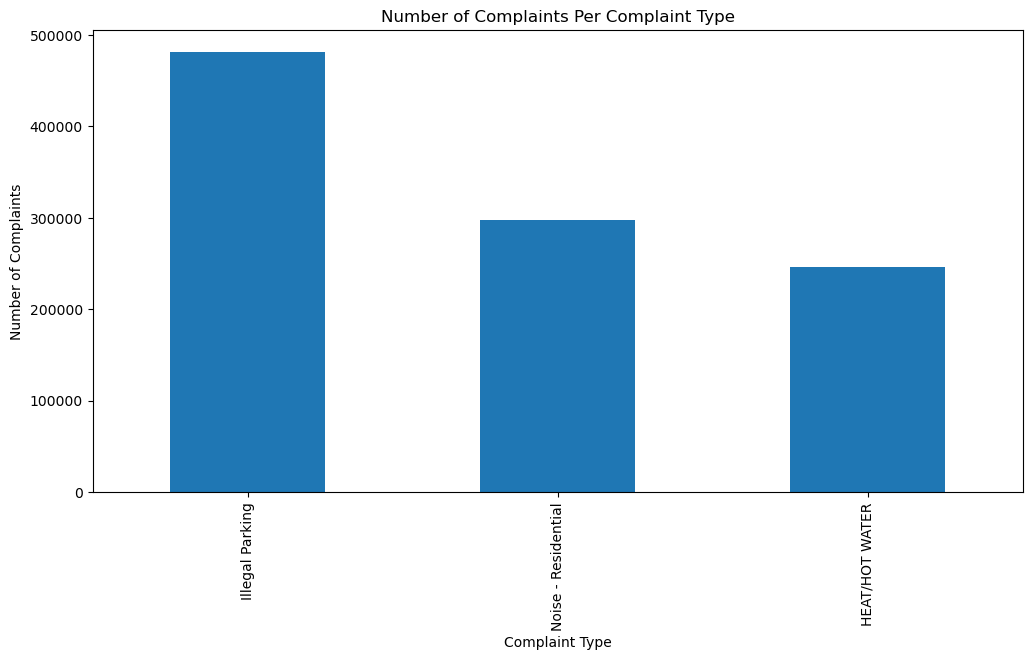

In [ ]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)

####

#### Visualization 2: What are the most common complaints in the immediate area?

In [ ]:
def plot_visual_2(dataframe):
    igure, axes = plt.subplots(figsize=(12, 6))
    
    # use bar chart
    dataframe.plot(kind='bar', x='complaint_type', y='total_complaints', ax=axes, legend=False)
    
    # labels
    axes.set_title("Number of Complaints Per Complaint Type")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Number of Complaints")
    
    plt.show()

In [ ]:
def get_data_for_visual_2():
    engine = create_engine(DB_URL)

    # Define the query to retrieve data for the specified time frame
    query = f"""
        SELECT
            complaint_type,
            COUNT(*) AS num_complaints
        FROM
            complaints
        WHERE
            zip_code = '10027'
            AND created_date >= '2023-03-01' 
            AND created_date <= '2024-02-29'
        GROUP BY
            complaint_type
        ORDER BY
            num_complaints DESC
        LIMIT 10;
    """
    # Use the engine to connect and execute the query
    with engine.connect() as conn:
        result = conn.execute(text(query))
        data = result.fetchall()

    # Convert the result to a Pandas DataFrame
    dataframe = pd.DataFrame(data, columns=['complaint_type','total_complaints'])

    return dataframe
    

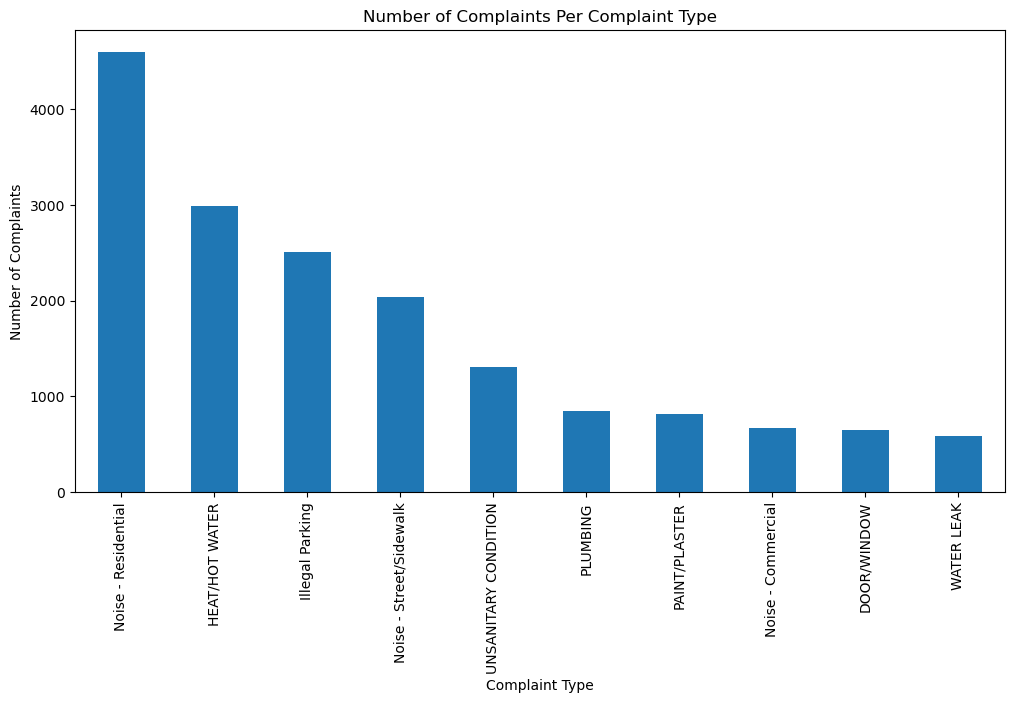

In [ ]:
some_dataframe = get_data_for_visual_2()
plot_visual_2(some_dataframe)

####

#### Visualization 3: Is there any correlation between rent, trees, and complaints at all?


In [ ]:
def plot_visual_3(dataframe):

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    
    # Plot rent vs. number of trees
    ax1.scatter(dataframe['rents'], dataframe['trees'], color='blue', alpha=0.5)
    ax1.set_title('Rent vs. Number of Trees by Zip Code')
    ax1.set_xlabel('Average Rent')
    ax1.set_ylabel('Number of Trees')
    
    # Plot rent vs. number of complaints
    ax2.scatter(dataframe['rents'], dataframe['complaints'], color='red', alpha=0.5)
    ax2.set_title('Rent vs. Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def get_data_for_visual_3():
        
    engine = create_engine(DB_URL)

    # Define the query to retrieve data for the specified time frame
    query = """
    WITH rent_data AS (
        SELECT
            zip_code,
            AVG(("Mar_2023" + "Apr_2023" + "May_2023" + "Jun_2023" + "Jul_2023" + "Aug_2023" + "Sep_2023" + "Oct_2023" + "Nov_2023" + "Dec_2023" + "Jan_2024") / 10) AS avg_rent
        FROM
            rents
        GROUP BY
            "zip_code"
    ),
    tree_data AS (
        SELECT
            zipcode AS zip_code,
            COUNT(*) AS tree_count
        FROM
            trees
        GROUP BY
            zipcode
    ),
    complaint_data AS (
        SELECT
            zip_code,
            COUNT(*) AS complaint_count
        FROM
            complaints
        GROUP BY
            zip_code
    )

    SELECT
        r.zip_code AS "Zipcode",
        r.avg_rent AS "rents",
        t.tree_count AS "trees",
        c.complaint_count AS "complaints"
    FROM
        rent_data r
    LEFT JOIN
        tree_data t ON r.zip_code = t.zip_code
    LEFT JOIN
        complaint_data c ON r.zip_code = c.zip_code
    """
    # Use the engine to connect and execute the query
    with engine.connect() as conn:
        result = conn.execute(text(query))
        data = result.fetchall()

    # Convert the result to a Pandas DataFrame
    dataframe = pd.DataFrame(data, columns=['Zipcode','rents','trees','complaints'])
    datafram=dataframe.dropna()

    return dataframe

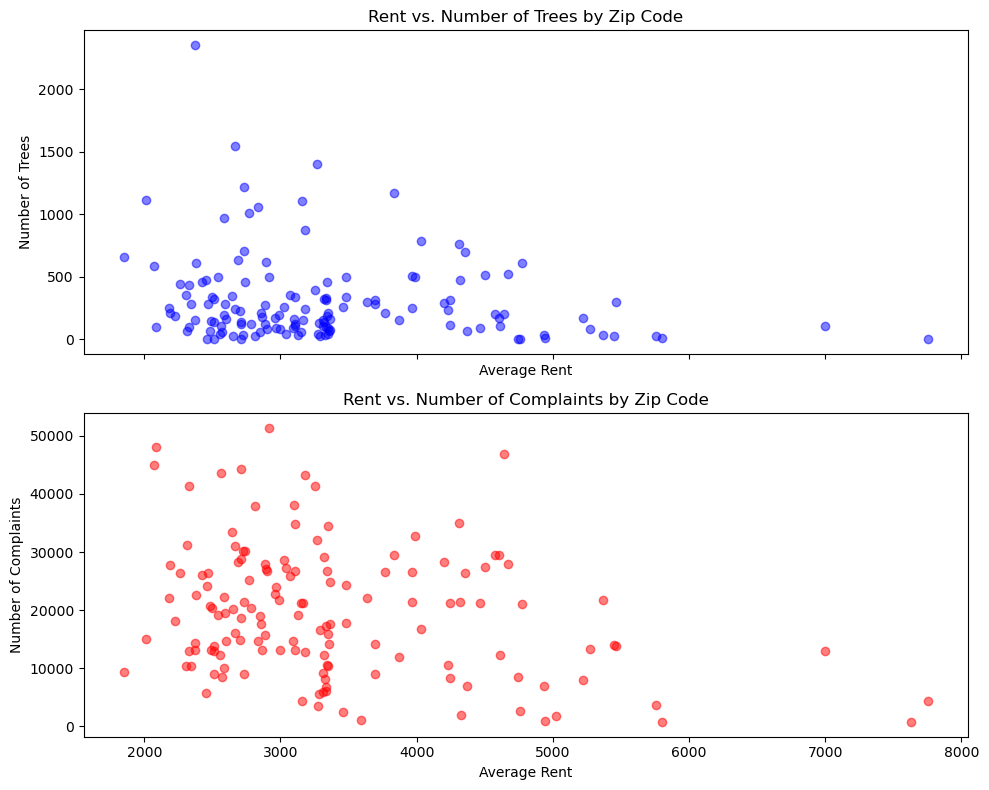

In [ ]:
some_dataframe = get_data_for_visual_3()
plot_visual_3(some_dataframe)

####

#### Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?

In [ ]:
def plot_visual_4(dataframe):
    df=dataframe
    # Bin the rents into $1000 bins
    df['rent_bins'] = pd.cut(df['rents'], bins=range(0, 11000, 1000), labels=[f'${i}-{i+1000}' for i in range(0, 10000, 1000)])
    filtered_df = df

    # Create a boxplot
    plt.figure(figsize=(12, 8))
    boxplot = filtered_df.boxplot(column='total_complaints', by='rent_bins', patch_artist=True, medianprops={'color':'black'})
    plt.suptitle('Boxplot of 311 Complaints by Rent Bins')
    plt.xlabel('Rent Bins')
    plt.ylabel('Number of 311 Complaints')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def get_data_for_visual_4():
    
    engine = create_engine(DB_URL)

    # Define the query to retrieve data for the specified time frame
    query = """
        SELECT
            rents."zip_code",
            AVG(rents."Jan_2024") AS rent,
            COUNT(*) AS num_complaints
        FROM
            rents
        JOIN
            complaints ON rents."zip_code" = complaints."zip_code"
        WHERE
            complaints.created_date BETWEEN '2023-03-01' AND '2024-02-29'
        GROUP BY
            rents."zip_code"
        LIMIT 10;
    """
    # Use the engine to connect and execute the query
    with engine.connect() as conn:
        result = conn.execute(text(query))
        data = result.fetchall()

    # Convert the result to a Pandas DataFrame
    dataframe = pd.DataFrame(data, columns=['zipcode','rents','total_complaints'])

    return dataframe

<Figure size 1200x800 with 0 Axes>

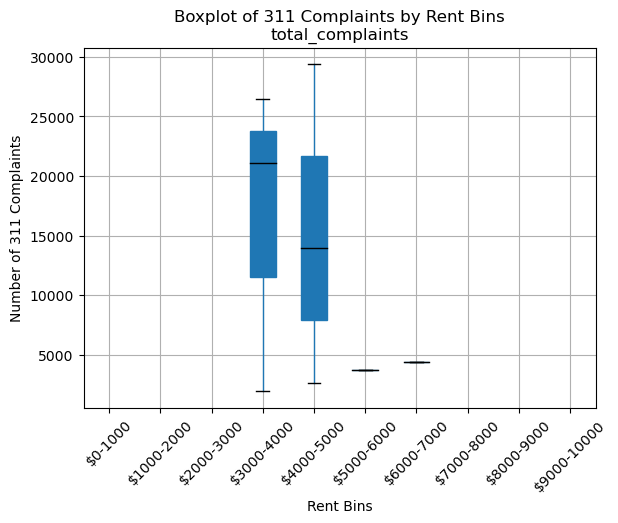

In [ ]:
some_dataframe = get_data_for_visual_4()
plot_visual_4(some_dataframe)

####

#### Visualization 5: Where were the recent 311 incidents reported from in the immediate area?


In [ ]:
def plot_visual_5(df):
    """Plot the location of 311 incidents reported within 1 kilometer radius of Columbia campus within timeframe
    
    Keyword arguments:
    df -- a dataframe contains location of the trees satisfies the requirements
    """
    
    # Plot the incidents and the buffered area on a map
    figure, axes = plt.subplots(figsize=(20, 10))

    # Plot incidents within the buffered area
    df.plot(ax=axes, marker='o', color='red', markersize=5, label='Complaints within 1km radius')

    plt.title('Reported 311 Incidents within the point')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    plt.show()

In [ ]:
def get_data_for_visual_5():
    """ 
    Write a query to get data from database for Visualization 5 and return to a dataframe.
    """
    
    QUERY_Visual5 = f"""
        SELECT the_geom as geom
        FROM complaints
        WHERE (created_date BETWEEN '2023-03-01' AND '2024-02-29')
        AND
            ST_DistanceSphere(
            ST_GeomFromText('POINT({longitude} {latitude})',4326),
            the_geom) < 1000
        """
    
    with engine.connect() as connection:
        gdf = gpd.read_postgis(QUERY_Visual5, connection)
        
    return gdf

In [ ]:
longitude = -73.96253174434912
latitude = 40.80737875669467

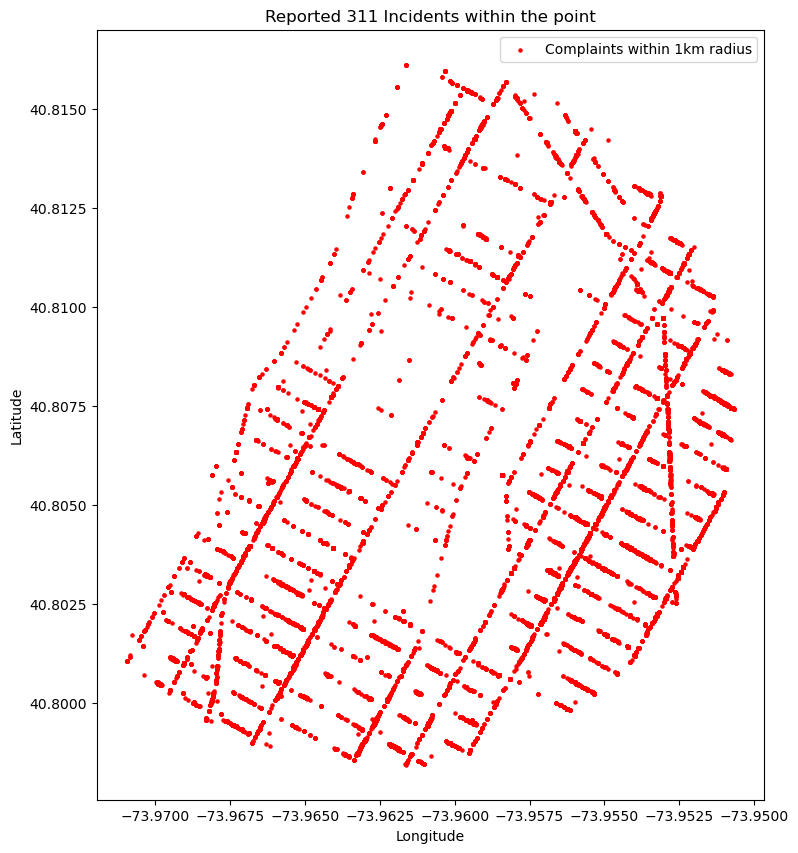

In [ ]:
df_visual5 = get_data_for_visual_5()
plot_visual_5(df_visual5)

####

#### Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?

In [ ]:
def plot_visual_6(gdf_trees, gdf_311):
    fig, ax = plt.subplots(figsize=(12, 8))

    gdf_trees.plot(ax=ax, color='green', edgecolor='black', label='Trees', markersize=10)
    gdf_311.plot(ax=ax, color='red', edgecolor='black', label='New Tree Requests', marker='s', markersize=10)

    ax.set_title('Geospatial Plot of Trees and New Tree Requests')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.show()
    

In [ ]:
def get_data_for_visual_6():
    
    query_trees = """
        SELECT
            "tree_id",
            "spc_common",
            ST_X("the_geom") AS "longitude",
            ST_Y("the_geom") AS "latitude"
        FROM
            "trees";
    """
    
    query_complaints = """
        SELECT
            "latitude",
            "longitude",
            "created_date"
        FROM
            "complaints"
        WHERE
            "created_date" BETWEEN '2023-03-01' AND '2024-02-29';
    """

    df_trees = pd.read_sql_query(query_trees, engine)
    df_311 = pd.read_sql_query(query_complaints, engine)
    

    geometry_trees = [shapely.geometry.Point(lon, lat) for lon, lat in zip(df_trees['longitude'], df_trees['latitude'])]
    geometry_311 = [shapely.geometry.Point(lon, lat) for lon, lat in zip(df_311['longitude'], df_311['latitude'])]
    

    gdf_trees = gpd.GeoDataFrame(df_trees, geometry=geometry_trees, crs='EPSG:4326')
    gdf_311 = gpd.GeoDataFrame(df_311, geometry=geometry_311, crs='EPSG:4326')
    
    return gdf_trees, gdf_311

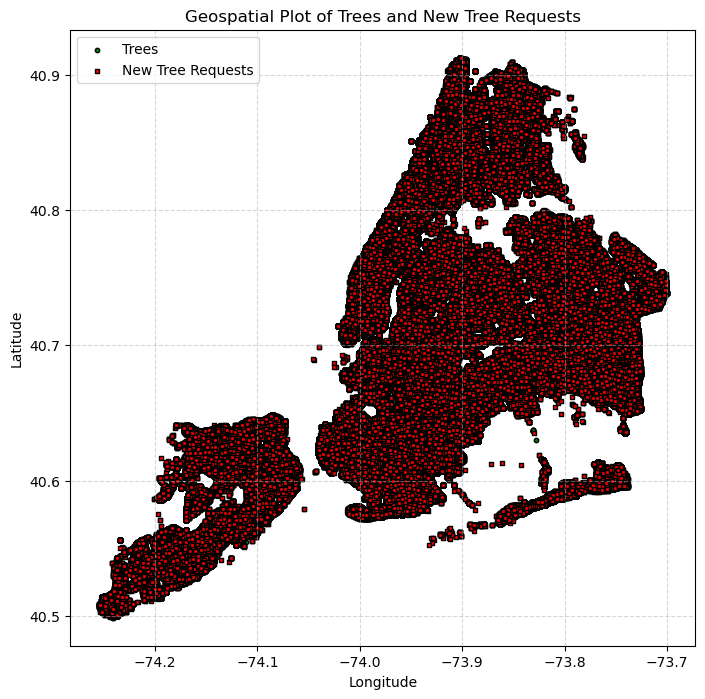

In [ ]:
gdf_trees, gdf_311 = get_data_for_visual_6()
plot_visual_6(gdf_trees, gdf_311)

####

## Visualization Extra Credit

#### Create a visual thats shows variation of rent for a zipcode 10027 across the year

In [ ]:
def get_rent_data(zipcode):
    engine = create_engine(DB_URL)
    query = f"""
    SELECT
        "Mar_2023", "Apr_2023", "May_2023", "Jun_2023",
        "Jul_2023", "Aug_2023", "Sep_2023", "Oct_2023", "Nov_2023", "Dec_2023"
    FROM
        rents
    WHERE 
        zip_code = '10027';
    """
    
    # Use the engine to connect and execute the query
    with engine.connect() as conn:
        result = conn.execute(text(query))
        data = result.fetchone()  # fetchone because we assume there's only one row per zipcode

    # Create a DataFrame with month names as columns
    months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    rent_data = {'Month': months, 'Average Rent': data}
    dataframe = pd.DataFrame(rent_data)

    # Convert the 'Month' column to include the year for plotting
    year = '2023'  # Assuming the year is 2023, adjust if necessary
    dataframe['Month'] = dataframe['Month'].apply(lambda x: f"{x}_{year}")
    dataframe['Month'] = pd.to_datetime(dataframe['Month'], format='%b_%Y')

    return dataframe




In [ ]:
def plot_rent_variation(dataframe, zipcode):
    figure, axes = plt.subplots(figsize=(12, 6))
    
    # Convert the 'month' column to datetime to help with sorting
    dataframe['Month'] = pd.to_datetime(dataframe['Month'], format='%b_%Y')
    
    # Sort the DataFrame by 'Month' after conversion
    dataframe.sort_values('Month', inplace=True)
    
    # Set the 'Month' column as the index
    dataframe.set_index('Month', inplace=True)
    
    # Plot the 'Average Rent' as a line plot
    dataframe['Average Rent'].plot(kind='line', marker='o', ax=axes)
    
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Labels and title
    axes.set_title(f"Monthly Average Rent Variation for Zipcode {zipcode} in 2023")
    axes.set_xlabel("Month")
    axes.set_ylabel("Average Rent ($)")
    
    plt.tight_layout()  # Adjust layout to fit the x-axis labels
    plt.show()

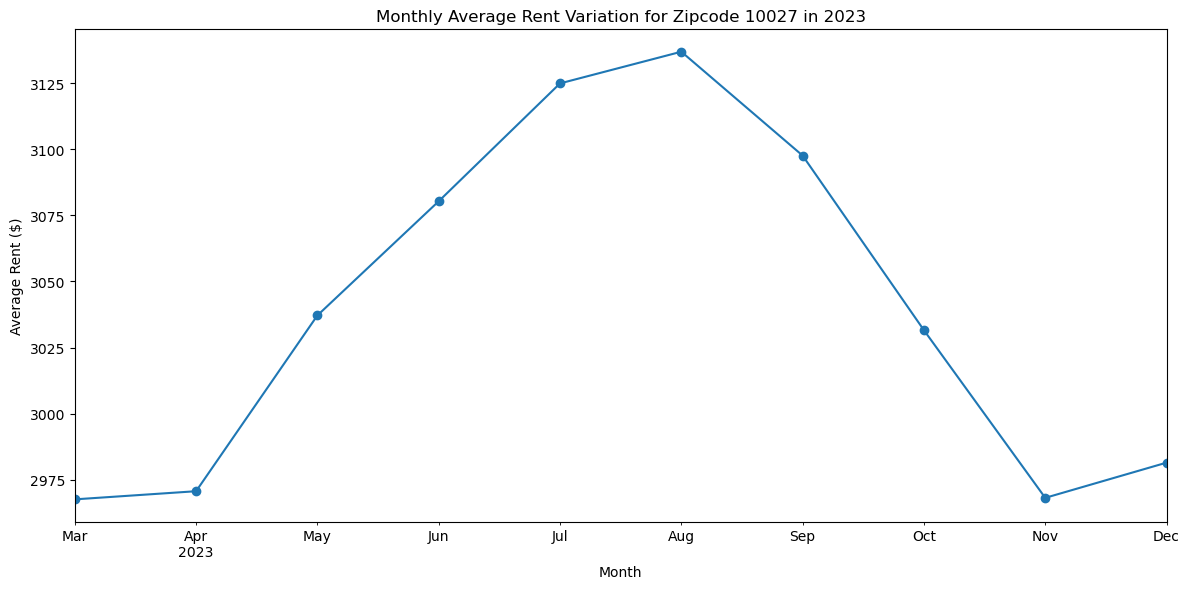

In [ ]:
df_rent = get_rent_data('10027')
plot_rent_variation(df_rent, '10027')